In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
from __future__ import print_function
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
from preprocess import *
from utils import *
import math

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Image loading and preprocessing


In [49]:
crop_size = (256, 256)

def preprocess_generator_train_test(generator):
    while True:
        batch = next(generator)
        batch_crops = np.zeros((batch.shape[0], crop_size[0], crop_size[1], 1))
        for i in range(batch.shape[0]):
            img = crop_img(batch[i], crop_size)
            img = center_img(img) # shift to -1,1
            channel = np.random.randint(0, 3)
            batch_crops[i] = img[:,:,channel:channel+1]
        yield batch_crops, batch_crops


def slice_img(img, slice_size):
    padded_size = (math.ceil(img.shape[0] / float(slice_size[0])) * slice_size[0],
                math.ceil(img.shape[1] / float(slice_size[1])) * slice_size[1],
                img.shape[2])

    padded_img = np.zeros(padded_size)
    padded_img[0:img.shape[0], 0:img.shape[1]] = img
    M, N = slice_size
    slices = np.array(
            [padded_img[x:x+M, y:y+N] for x in range(0, padded_img.shape[0], M)
                                      for y in range(0, padded_img.shape[1], N)]
    )
    return slices


def deslice_img(slices, img_size):
    slice_size = slices[0].shape
    img = np.zeros(img_size)

    y, x = 0, 0
    for s in slices:
        y_to = min(y+slice_size[0], img.shape[0])
        x_to = min(x+slice_size[1], img.shape[1])
        img[y:y_to, x:x_to] = s[0:y_to-y, 0:x_to-x]
        if x + slice_size[1] >= img.shape[1]:
            x = 0
            y += slice_size[0]
        else:
            x += slice_size[1]

    return img


def preprocess_generator_slice(generator):
    while True:
        batch = next(generator)
        for img in batch:
            img = center_img(img)
            yield slice_img(img, crop_size)


downscale_fact = 2
image_height_orig = 720
image_width_orig = 1280
image_height_ds = image_height_orig // downscale_fact
image_width_ds = image_width_orig // downscale_fact

train_ds, test_ds = create_dataflows('../images', (image_height_ds, image_width_ds), 16)

train_ds_prep = preprocess_generator_train_test(train_ds)
test_ds_prep = preprocess_generator_train_test(test_ds)

# train_ds_mapped = pair_mapping(train_ds)
# test_ds_mapped = pair_mapping(test_ds)
plt.gray()

Found 3407 images belonging to 1 classes.
Found 851 images belonging to 1 classes.


<Figure size 640x480 with 0 Axes>

(256, 256, 1)
(256, 256, 1)


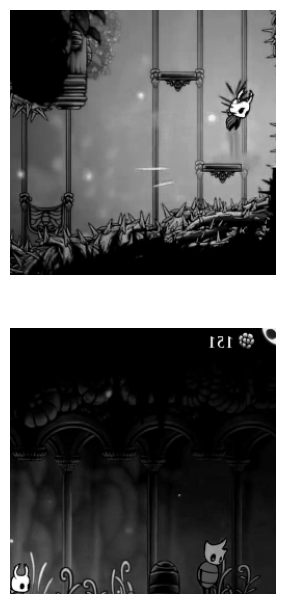

In [50]:
plt.figure(figsize=(20, 20))
images = next(train_ds_prep)
for i, image in enumerate(images[0][:2]):
    print(image.shape)
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(decenter_img(image))
    plt.axis("off")

train_ds.reset()

# The Model of the AutoEncoder

In [5]:
def ssim_loss(y_true, y_pred):
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim_multiscale(decenter_img(y_true), decenter_img(y_pred), 1.0, filter_size=3))

total_variation_weight = 1e-10

def tv_loss(y_true, y_pred):
    # tv = tf.reduce_sum(tf.image.total_variation(decenter_img(y_pred))) # tv1: total var of y_pred
    # tv = tf.reduce_sum(tf.image.total_variation(tf.abs(decenter_img(y_pred) - decenter_img(y_true)))) # tv3, no high hopes, just bull
    tv = tf.nn.relu(tf.reduce_sum(tf.image.total_variation(decenter_img(y_pred))) - tf.reduce_sum(tf.image.total_variation(decenter_img(y_true)))) # tv4
    return ssim_loss(y_true, y_pred) + total_variation_weight * tv

In [141]:
from keras import backend as K, losses
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ZeroPadding2D, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate
from keras.models import Model, Sequential

def create_improved_baseline_model_12x_comp(image_size):
    ### Encoder ###

    model = Sequential()
    model.add(Conv2D(16, kernel_size=(7, 7), strides=(2, 2), kernel_initializer='he_normal',
                     padding='same', input_shape=(image_size[0], image_size[1], 1)))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(11, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu', name='encoded', dtype='float16'))


    ### Decoder ###

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization()) #
    model.add(Activation('leaky_relu'))

    # model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')) #
    # model.add(BatchNormalization()) #
    # model.add(Activation('leaky_relu')) #

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization()) #
    model.add(Activation('leaky_relu'))

    # model.add(Conv2DTranspose(16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')) #
    # model.add(BatchNormalization()) #
    # model.add(Activation('leaky_relu')) #

    # model.add(Conv2DTranspose(16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')) #
    # model.add(BatchNormalization()) #
    # model.add(Activation('leaky_relu')) #

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization()) #
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(1, kernel_size=(7, 7), strides=(2, 2), activation='tanh', padding='same', name='decoded'))

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model

In [144]:
autoencoder = create_improved_baseline_model_12x_comp(crop_size)
# autoencoder.summary()

('shape of encoded', (None, 16, 16, 11))
('shape of decoded', (None, 256, 256, 1))


In [145]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0025), loss='mae')

# Training the AutoEncoder

In [123]:
# Note: Delete the logs before running this. The command below should do this, but I would prefer to do it manually.
# !RMDIR "./logs/" /S /Q

# Launching Tensorboard
%tensorboard --logdir ./logs/fit --host localhost #--port:6006
# localhost:6006 in browser

UsageError: Line magic function `%tensorboard` not found.


In [124]:
from keras.callbacks import CSVLogger, TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Set APPEND=TRUE if you are continuing the training, so that the log.csv wouldn't be reset!
csv_logger = CSVLogger('log.csv', append=False, separator=';')

In [146]:
autoencoder.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = (train_ds.n * 1) // train_ds.batch_size,
                validation_steps = (test_ds.n * 1) // test_ds.batch_size,
                epochs=60,
                callbacks=[csv_logger, tensorboard_callback],
                verbose=1)

Epoch 1/60
212/212 [==============================] - 53s 239ms/step - loss: 0.1317 - val_loss: 0.1065
Epoch 2/60
212/212 [==============================] - 48s 229ms/step - loss: 0.0990 - val_loss: 0.1111
Epoch 3/60
212/212 [==============================] - 49s 230ms/step - loss: 0.0864 - val_loss: 0.1522
Epoch 4/60
212/212 [==============================] - 49s 231ms/step - loss: 0.0847 - val_loss: 0.1185
Epoch 5/60
212/212 [==============================] - 49s 231ms/step - loss: 0.0819 - val_loss: 0.0890
Epoch 6/60
212/212 [==============================] - 49s 231ms/step - loss: 0.0778 - val_loss: 0.1410
Epoch 7/60
212/212 [==============================] - 49s 231ms/step - loss: 0.0677 - val_loss: 0.0647
Epoch 8/60
212/212 [==============================] - 49s 230ms/step - loss: 0.0625 - val_loss: 0.0702
Epoch 9/60
212/212 [==============================] - 49s 230ms/step - loss: 0.0608 - val_loss: 0.0775
Epoch 10/60
212/212 [==============================] - 49s 231ms/step - l

Epoch 1/10
106/106 [==============================] - 27s 236ms/step - loss: 0.1739 - val_loss: 0.2374
Epoch 2/10
106/106 [==============================] - 25s 237ms/step - loss: 0.1053 - val_loss: 0.1274
Epoch 3/10
106/106 [==============================] - 25s 238ms/step - loss: 0.0978 - val_loss: 0.1473
Epoch 4/10
106/106 [==============================] - 25s 238ms/step - loss: 0.0896 - val_loss: 0.0869
Epoch 5/10
106/106 [==============================] - 26s 242ms/step - loss: 0.0929 - val_loss: 0.0752
Epoch 6/10
106/106 [==============================] - 25s 239ms/step - loss: 0.0899 - val_loss: 0.0767
Epoch 7/10
106/106 [==============================] - 25s 237ms/step - loss: 0.0866 - val_loss: 0.1733
Epoch 8/10
106/106 [==============================] - 26s 243ms/step - loss: 0.0890 - val_loss: 0.1245
Epoch 9/10
106/106 [==============================] - 25s 237ms/step - loss: 0.0872 - val_loss: 0.0725
Epoch 10/10
106/106 [==============================] - 25s 239ms/step - loss: 0.0865 - val_loss: 0.0835




Epoch 57/60
212/212 [==============================] - 49s 231ms/step - loss: 0.0420 - val_loss: 0.0657
Epoch 58/60
212/212 [==============================] - 50s 237ms/step - loss: 0.0422 - val_loss: 0.0476
Epoch 59/60
212/212 [==============================] - 51s 242ms/step - loss: 0.0426 - val_loss: 0.0501
Epoch 60/60
212/212 [==============================] - 50s 239ms/step - loss: 0.0430 - val_loss: 0.0576

In [149]:
# Saving the model:
autoencoder.save('../model-saves/separate-channels/')

INFO:tensorflow:Assets written to: ../model-saves/separate-channels/assets


INFO:tensorflow:Assets written to: ../model-saves/separate-channels/assets


In [ ]:
# Loading the model:
# autoencoder = keras.models.load_model('../model-saves/improved-12x-RGB-v2/', custom_objects={
#     'ssim_loss': ssim_loss
# })

# autoencoder.summary()

# Running the AutoEncoder

In [150]:
img_number = 16
display_img_number = 4

test_set = []
for i in range(img_number):
    test_set.append(next(preprocess_generator_slice(test_ds)))

1/1 [==============================] - 0s 27ms/step
0.102442086
1/1 [==============================] - 0s 24ms/step
0.11418182
1/1 [==============================] - 0s 24ms/step
0.12742442
1/1 [==============================] - 0s 23ms/step
0.07555342
1/1 [==============================] - 0s 24ms/step
0.043767214
1/1 [==============================] - 0s 28ms/step
0.14356428
1/1 [==============================] - 0s 27ms/step
0.11315268
1/1 [==============================] - 0s 24ms/step
0.12352675
1/1 [==============================] - 0s 24ms/step
0.14062476
1/1 [==============================] - 0s 27ms/step
0.090622365
1/1 [==============================] - 0s 23ms/step
0.09012312
1/1 [==============================] - 0s 24ms/step
0.114551365
1/1 [==============================] - 0s 25ms/step
0.12100774
1/1 [==============================] - 0s 26ms/step
0.097859085
1/1 [==============================] - 0s 26ms/step
0.11851424
1/1 [==============================] - 0s 26ms/ste

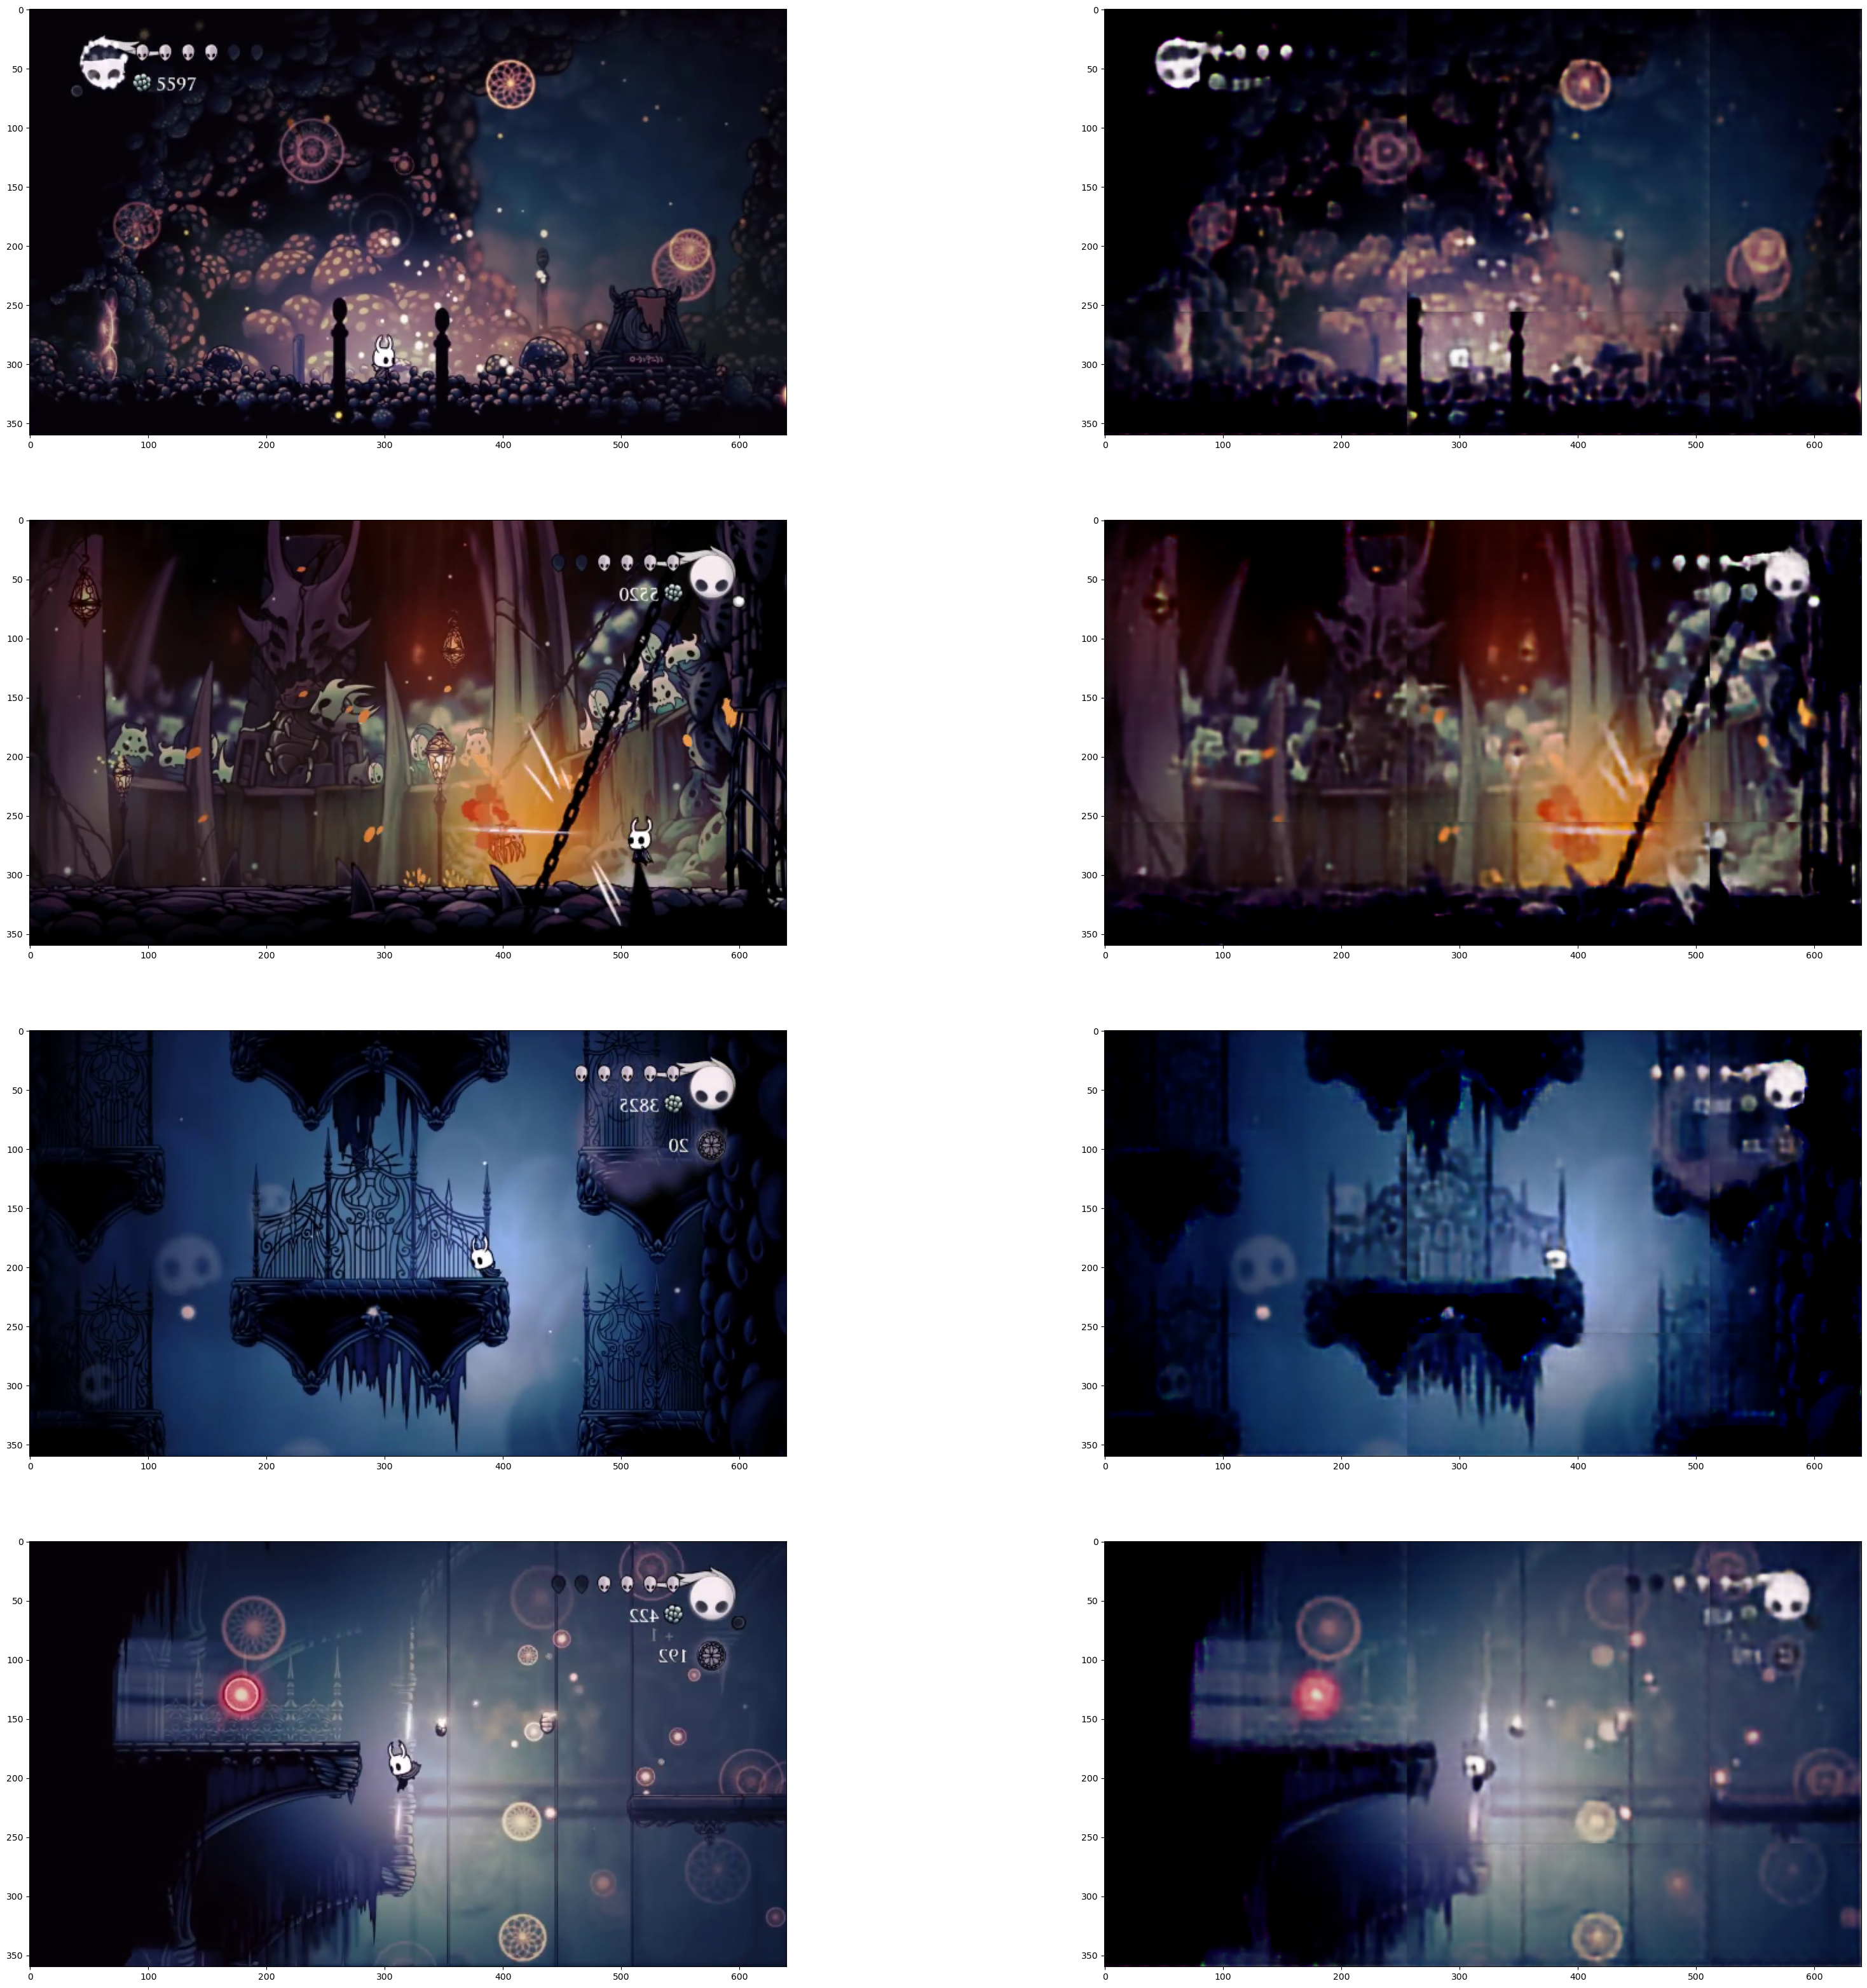

In [151]:
import numpy as np

img_size = (image_height_ds, image_width_ds, 3)

fig = plt.figure(figsize=(40, 40))


ssim_values = []
for i in range(img_number):
    image_slices = test_set[i]
    batch = []
    for img in image_slices:
        for c in range(0, img.shape[2]):
            batch.append(img[:,:,c:c+1])
    batch = np.array(batch)
    # image_slices = next(preprocess_generator_slice(test_ds))

    decoded_slices = autoencoder.predict(batch)
    rgb_slices = np.zeros((image_slices.shape[0], decoded_slices.shape[1], decoded_slices.shape[2], 3))
    for j in range(0, decoded_slices.shape[0], 3):
        rgb_slices[j//3][:,:,0] = decoded_slices[j][:,:,0]
        rgb_slices[j//3][:,:,1] = decoded_slices[j+1][:,:,0]
        rgb_slices[j//3][:,:,2] = decoded_slices[j+2][:,:,0]
    decoded_img = deslice_img(rgb_slices, img_size)
    decoded_img = decenter_img(decoded_img)

    original_image = decenter_img(deslice_img(image_slices, img_size))

    ssim = 1 - tensorflow.image.ssim_multiscale(original_image, decoded_img, 1.0, filter_size=3)
    ssim_values.append(ssim)
    print(ssim.numpy())

    if i < display_img_number:
        plt.subplot(display_img_number, 2, i*2+1)
        plt.imshow(original_image)
        plt.subplot(display_img_number, 2, i*2+2)
        plt.imshow(decoded_img)

        # plt.subplot(display_img_number, 5, i*5+3)
        # plt.imshow(decoded_img[:,:,0:1])
        #
        # plt.subplot(display_img_number, 5, i*5+4)
        # plt.imshow(decoded_img[:,:,1:2])
        #
        # plt.subplot(display_img_number, 5, i*5+5)
        # plt.imshow(decoded_img[:,:,2:3])

print("AVERAGE SSIM: ")
print(np.array(ssim_values).mean())

# rescaled_img = cv2.resize(decenter_img(in_img), (in_img.shape[0] // 3, in_img.shape[1] // 3))